In [1]:
import pandas as pd
from persim import PersImage
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np

# Loading Persistence Diagrams $H_0$
Remember to filter out **inf** point

In [2]:
pds = []
non_train_PATH = 'experiment_data/pd_intervals/not-trained/'#pd-model_0_ne-0.npz'
train_PATH = 'experiment_data/pd_intervals/trained/'#pd-model_0_ne-5.npz'
for i in range(50):
    non_train_pd = np.load(non_train_PATH+'pd-model_'+str(i)+'_ne-0.npz')
    pds.append(non_train_pd['pd'][0])
for i in range(50):
    train_pd = np.load(train_PATH+'pd-model_'+str(i)+'_ne-5.npz')
    pds.append(train_pd['pd'][0])

# Creating Persistence Images for $H_0$

In [53]:
pims = []
num_networks = 100
for i in range(num_networks):
    pim = PersImage(spread=0.15, pixels=[10,10], verbose=False)
    img = pim.transform(pds[i][:-1])
    label = "not-trained" if i<50 else "trained"
    pims.append((img,label))

In [55]:
np.savez('experiment_data/persistent_images/mnist_nn_pimgs',pimgs=pims)

In [57]:
persist_images = np.load('experiment_data/persistent_images/mnist_nn_pimgs.npz')

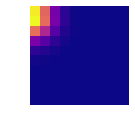

In [157]:
ax = plt.subplot(131)
#plt.title("PI for $H_0$\nwith 10x10 pixels")
pim.show(pims[0][0], ax)

# Building a distance matrix 

In [63]:
from sklearn.metrics.pairwise import euclidean_distances

In [81]:
dist_mat = np.zeros((num_networks,num_networks))
start = time.time()
calculated = {}
visited_pairs = set()
for i in range(num_networks):
    for j in range(num_networks):
        if i == j:
            dist_mat[i][j] = 0.
        elif (i,j) not in visited_pairs and (j,i) not in visited_pairs:
            visited_pairs.add((i,j))
            visited_pairs.add((j,i))
            dist = (pims[i][0]-pims[j][0])**2
            dist = np.sum(dist)
            dist = np.sqrt(dist)
            dist_mat[i][j] = dist
            calculated[(i,j)] = dist_mat[i][j]
            calculated[(j,i)] = dist_mat[i][j]
        else:
            dist_mat[i][j] = calculated[(i,j)]
end = time.time()
elapsed = (end-start)/60.
print("Elapsed Time: "+str(elapsed)+" minutes." )

Elapsed Time: 0.0011316855748494466 minutes.


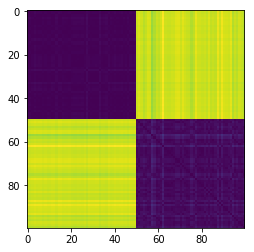

In [84]:
# Visualizing Distance matrix
plt.imshow(dist_mat)

# Clustering our NN using the Distance Matrix

In [85]:
from sklearn.cluster import KMeans
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

In [86]:
kmeans = KMeans(n_clusters=2, random_state=423).fit(dist_mat)

In [89]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

# Visualizing Clusters Using t-SNE

In [91]:
from sklearn.manifold import TSNE

In [111]:
pims[0][0].reshape(-1)

(100,)

In [131]:
X = np.array([])
for image in pims:
    X = np.append(X,image[0].reshape(-1))

In [132]:
X = X.reshape(-1,100)

In [133]:
X_embedded = TSNE(n_components=2).fit_transform(X)

In [141]:
#X_embedded
cluster_labels = []
for cluster in kmeans.labels_:
    if cluster == 1:
        cluster_labels.append("not-trained")
    else:
        cluster_labels.append("trained")

In [143]:
#cluster_labels

In [136]:
#a4_dims = (11.7,11.7)

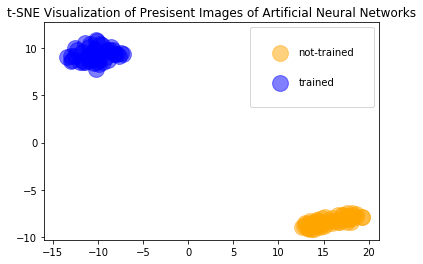

In [156]:
# color for map
#https://stackoverflow.com/questions/48512690/matplotlib-change-marker-color-based-on-label-value
intent_legend = {'trained':'blue',
                 'not-trained':'orange'}
col2intent = {'blue':'trained',
            'orange':'not-trained'}

color= [intent_legend[cluster_labels[idx]] for idx in range(len(cluster_labels))]
size = [2.5*len(color)]
fig, ax = plt.subplots()
for i in range(len(X_embedded)):
    plt.scatter(x=X_embedded[i][0],
                y=X_embedded[i][1],
                c=color[i],
                label=col2intent[color[i]],
                   alpha=0.5,
               s=size)
# https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend?noredirect=1&lq=1
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
#https://stackoverflow.com/questions/20048352/how-to-adjust-the-size-of-matplotlib-legend-box
plt.legend(by_label.values(), by_label.keys(),borderpad=2,labelspacing=2,fontsize= 'medium') 
#ax.grid(True)
plt.title('t-SNE Visualization of Presisent Images of Artificial Neural Networks')
fig = ax.get_figure()
fig.savefig("experiment_data/clustering/nn_cluster_pims.png",bbox_inches="tight",dpi=300)